# Mount Google drive and import files

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My*/ALE_Python/*.py /content/
#!rm -r -f training_wave_25x25_2/*

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
drive.mount('/content/drive')
!cp drive/My*/ALE_Python/LinTanh/*.pkl /content/
!cp drive/My*/ALE_Python/LinTanh/*.h5 /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle
import tensorflow as tf

Encoder_size = 20;
RNN_size     = 10;

gridtype = 'Eulerian'; #Eulerian , ALE

qq = pickle.load( open( "ALE_burgers_FreeFree_kx=1_kw=4.pkl", "rb" ) )

train_history = pickle.load( open( "/content/burgers_"+gridtype+"_Ensize"+str(Encoder_size)+"_RNNsize"+str(RNN_size)+"_history.pkl", "rb" ) )
model = tf.keras.models.load_model('burgers_'+gridtype+'_Ensize'+str(Encoder_size)+'_RNNsize'+str(RNN_size)+'.h5')

if gridtype == 'Eulerian':
  qq.x = qq.x*0;

# Load Auto-encoder

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os as os
import datetime
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import time as time
from scipy.optimize import minimize
from numpy.linalg import norm

equation = 'burgers'; # burgers, Lconv, wave

if equation == 'burgers':
    from snapshot_gen_burgers import snapshot_gen_burgers as snapshot_gen
    ymin, ymax = 0.7, 1.3
    wave_speed = 0;
    bc         = 0.8
    batch_repeat = 2
    x_mid_0 = 0.5;
    xmax = 2.5;
    tmax = 1;
    Nx = 250;
    Ny = 250;
    Nt = 125;
    #  ALE optimization parameters
    k_x = 1;
    k_w = 4;
    # ALE optimization hyper-parameters
    Gamma_0_x = 1e0;
    Gamma_0_t = 1e0;
    size_x = 15;
    size_t = 5;
elif equation == 'Lconv':
    from snapshot_gen import snapshot_gen_v1 as snapshot_gen
    ymin, ymax = -0.1, 1.1
    wave_speed = 0.5;
    bc = 0
    batch_repeat = 2.
    x_mid_0 = 0.5;
elif equation == 'wave':
    from snapshot_gen_wave import snapshot_gen_wave as snapshot_gen
    ymin, ymax = -1.1, 1.1
    wave_speed = 0;
    bc = 0
    batch_repeat = 2
    x_mid_0 = 0.5;
    xmax = 1;#2.5;
    tmax = 1;
    Nx = 500;
    Ny = 500
    Nt = 2000;
    #  ALE optimization parameters
    k_x = 1*2;
    k_w = 2;
    # ALE optimization hyper-parameters
    Gamma_0_x = 1e0;
    Gamma_0_t = 1e0;
    size_x = 5;
    size_t = 5;#15;

maxiter = 10;

from snapshot_gen_burgers import fd_normal

from snapshot_gen_burgers import snapshot_decode

#from objective_ALE import callbackF

from objective_ALE import objective_ALE_clean as objective_fun
from objective_ALE import constraint_fun

from objective_ALE import gridgen_coarse_UV_fine
from objective_ALE import SVD_project
from objective_ALE import grid_spacing
from objective_ALE import interp1d_loop

from objective_ALE import UV_init_boundary
from objective_ALE import UV_init
from objective_ALE import UV_boundary

boundary_function_map = {
    # Make initial condition uniform
#    'UV_init': UV_init,
    # Free initial condition
    'UV_init': lambda V: V,
    # Make boundary fixed
    'UV_boundary': UV_boundary
    # Free boundary
#    'UV_boundary': lambda U: U
}

#from scipy.interpolate import interp1d as interp1
#from myplot import myplot
#%%
x_0 = np.linspace(0,xmax,Nx);
M_x_0 = np.repeat(x_0,Nt,axis=0).reshape(Nx,Nt);

t_0 = np.linspace(0,tmax,Nt);
M_t_0 = np.repeat(t_0,Nx,axis=0).reshape(Nt,Nx).T;

dxmin = 1/Nx/10;
#%% Snapshot generation
(x_train_org, y_train_org, x, t) = snapshot_gen(xmax, tmax, x_mid_0, Nx, Nt, wave_speed, batch_repeat)
X_E_FOM = y_train_org[0,:,:].reshape(Nx,Nt);

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
plt.plot(x, X_E_FOM[:,0] )
plt.plot(x, X_E_FOM[:,-1], linestyle='dotted' )
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
plt.ylim(ymin, ymax )

plt.show()
#%% ALE optimization parameters and hyper-parameters to dictionary 
k = {
  "x": k_x,
  "w": k_w
      }

Gamma_0 = {
        "x": Gamma_0_x, 
        "t": Gamma_0_t
           }
#%% Inital condition for basis functions
ix_fine = np.linspace(0,Nx-1,Nx);
it_fine = np.linspace(0,Nt-1,Nt);

it = list(np.floor(np.linspace(0,Nt-1,size_t)));
ix = list(np.floor(np.linspace(0,Nx-1,size_x)));

d0 = 0;
U_x = d0*np.ones((Nx ,k['x']))/np.sqrt(k['x']);
V_x = np.linspace(0,tmax,Nt) *  np.ones((k['x'],Nt))/np.sqrt(k['x']);
[U_x , V_x] = UV_init_boundary(U_x , V_x, boundary_function_map);


U_x = np.take(U_x,ix,axis=0); # U_x = U_x(ix,: );
V_x = np.take(V_x,it,axis=1); # V_x = V_x(: ,it);
#
q =  np.concatenate((U_x.reshape(size_x*k['x']),  V_x.reshape(k['x'] * size_t ) )); #q = U_x.reshape(size_x*k['x'])  V_x.reshape(k['x'] * size_t )   #[U_d(:);V_d(:)];
Flag = [U_x.size, V_x.size]; #Flag = [length(U_d(:)), length(V_d(:))];
#
#%% Regularization terms (Smoothness)
Gamma_x = fd_normal(Nx,3,ix_fine,2);
Gamma_t = fd_normal(Nt,3,it_fine,2);

Snapshot generator Burgers equation
0.9475724697113037


In [0]:
#%%
[M_x_ALE, dx, U_xx, V_xx] = gridgen_coarse_UV_fine(qq.x, 
                           k_x, Flag, Nx, Nt,
                           size_x, ix, ix_fine, 
                           size_t, it, it_fine,
                           M_x_0,
                           boundary_function_map,
                           mykind='linear');
#
M_w_ALE = interp1d_loop(M_x_0, X_E_FOM, M_x_ALE, Nx, Nt, bc, mykind='linear');
#
M_w_Proj, U, V = SVD_project(M_w_ALE, k_w, output_UV = True);
#
X_ROM_Proj = interp1d_loop(M_x_ALE, M_w_Proj, M_x_0, Nx, Nt, bc);

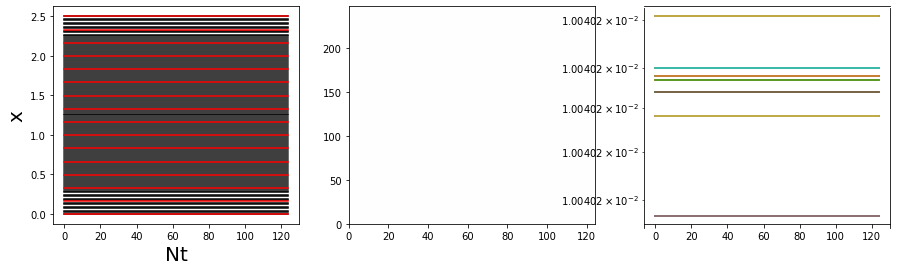

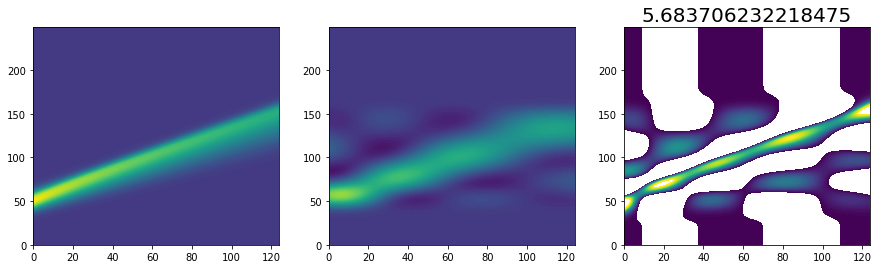

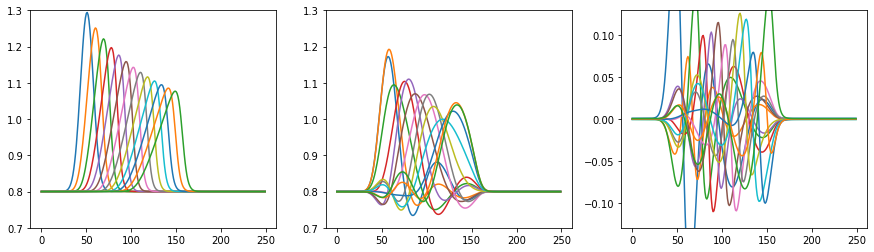

In [6]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import ticker, cm

fig_ALE = plt.figure(figsize=(15, 4));
# Plot ALE Grid
ax1 = plt.subplot(131)
plt.plot(np.transpose(M_x_ALE[np.linspace(1,Nx,101).astype(int)-1,:]),'k-')
plt.plot(np.transpose(M_x_ALE[np.linspace(1,Nx,16).astype(int)-1,:]),'-r')
plt.xlabel('Nt',  fontsize=20)
plt.ylabel('x' ,  fontsize=20)
# ALE Grid Spacing - Contour
ax1 = plt.subplot(132)
cf = plt.contourf( grid_spacing(M_x_ALE).T , locator=ticker.LogLocator(), cmap=cm.bwr_r ); 
fig.colorbar(cf)
# ALE Grid Spacing - Line plots
ax1 = plt.subplot(133)
plt.semilogy( grid_spacing(M_x_ALE) );
 
plt.show();
fig_ALE.savefig('fig_ALE', format="svg")
#%%
fig = plt.figure(figsize=(15, 4));
ax1 = plt.subplot(131)
plt.contourf(X_E_FOM, np.linspace(ymin, ymax, 100))

ax1 = plt.subplot(132)
plt.contourf(X_ROM_Proj,  np.linspace(ymin, ymax, 100))

ax1 = plt.subplot(133)
plt.contourf(X_E_FOM-X_ROM_Proj,  np.linspace(0, 0.1*ymax, 100))
plt.title(str(norm(X_E_FOM-X_ROM_Proj)),  fontsize=20)

plt.show()
#%%
dNt = 10;

fig = plt.figure(figsize=(15, 4));
ax1 = plt.subplot(131)
plt.plot(X_E_FOM[:,0:Nt:dNt])
#plt.plot(X_E_FOM[:,-1]);
plt.ylim(ymin, ymax )

ax1 = plt.subplot(132)
plt.plot(X_ROM_Proj[:,0:Nt:dNt])
plt.ylim(ymin, ymax )

ax1 = plt.subplot(133)
plt.plot(X_E_FOM[:,0:Nt:dNt] - X_ROM_Proj[:,0:Nt:dNt] )
plt.ylim(-0.1*ymax, 0.1*ymax )

plt.show()

# Evaluate RNN

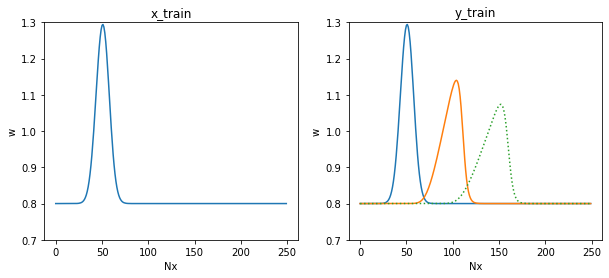

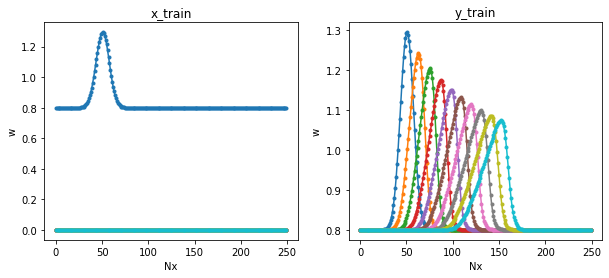

In [7]:
x_train = np.zeros((1, Nt, Ny))
y_train = np.zeros((1, Nt, Ny))
x_train[0,0,:]=M_w_ALE[:,0]
for tcount in range(Nt):
    y_train[0,tcount,:] = M_w_ALE[:,tcount]
#%%
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
plt.plot(x_train[0,0,:] )
plt.plot(x_train[0,-1,:], linestyle='dotted' )
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
plt.ylim(ymin, ymax )

ax1 = plt.subplot(122)
plt.plot(y_train[0,0,:] )
plt.plot(y_train[0,int(Nt/2),:] )
plt.plot(y_train[0,-1,:], linestyle='dotted' )

plt.xlabel('Nx')
plt.ylabel('w')
plt.title('y_train')
plt.ylim(ymin, ymax )

plt.show()
#%%
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
#plt.plot(x_train[0,0,:] )
#plt.plot(x_train[0,-1,:], linestyle='dotted' )
plt.plot(np.transpose(x_train[0,np.linspace(1,Nt,10).astype(int)-1,:]),'.-')
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
#plt.ylim(ymin, ymax )

ax1 = plt.subplot(122)
#plt.plot(y_train[0,0,:] )
#plt.plot(y_train[0,int(Nt/2),:] )
#plt.plot(y_train[0,-1,:], linestyle='dotted' )
plt.plot(np.transpose(y_train[0,np.linspace(1,Nt,10).astype(int)-1,:]),'.-')

plt.xlabel('Nx')
plt.ylabel('w')
plt.title('y_train')
#plt.ylim(ymin, ymax )

plt.show()

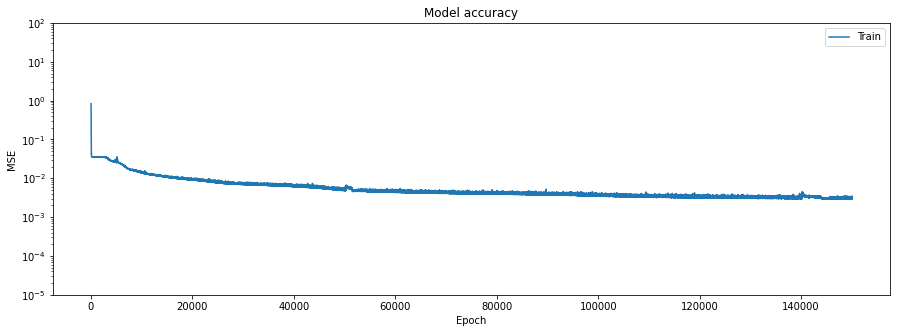

1/1 - 0s - loss: 0.0033 - mean_absolute_error: 0.0033
1.162243366241455


In [8]:
#%% Plot training & validation accuracy values
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot()
plt.semilogy(train_history['mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim(1e-5, 1e-1)
plt.ylim(1e-5, 1e2)
plt.show()

print('===============================')
t = time.time()
model.evaluate(x_train, y_train, verbose=2);
t = time.time() - t
print(t)
print('===============================')

In [9]:
train_history['mean_absolute_error'][-1]

0.003084109164774418

In [0]:
Npred    = int(1.5*Nt);
x_pred   = np.zeros((1, Npred, Ny))
x_pred[0,0,:]   = x_train[0,0,:]
y_pred_M = model.predict( x_pred )

#decode_speed = 0
y_pred_dec_M = y_pred_M.copy()
y_train_M = y_train.copy()

bc = x_pred[0,0,0]

In [0]:
from scipy.interpolate import interp1d as interp1

it_fine_ext = np.linspace(0,Npred-1,Npred);

M_x_0_ext = np.repeat(x_0,Npred,axis=0).reshape(Nx,Npred);

V_xx_ext = np.zeros((k_x,Npred));
for kcount in range(k_x):
    V_x_fun = interp1(it_fine, V_xx[kcount,:], kind='linear', fill_value = "extrapolate");
    V_xx_ext[kcount,:] = V_x_fun(it_fine_ext);

M_x_ALE_ext = M_x_0_ext + np.dot(U_xx,V_xx_ext)

y_pred_dec_M = interp1d_loop(M_x_ALE_ext, y_pred_dec_M[0,:,:].T, M_x_0_ext, Nx, Npred, bc);

Snapshot generator Burgers equation
1.4753682613372803


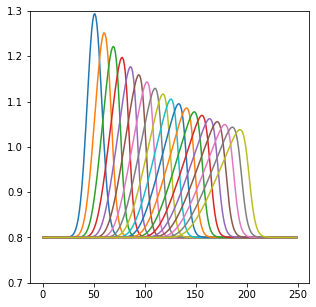

In [12]:
(x_train_org, y_train_org, x, t) = snapshot_gen(xmax, Npred/Nt*tmax, x_mid_0, Nx, Npred, wave_speed, batch_repeat)
X_E_FOM_ext = y_train_org[0,:,:].reshape(Nx,Npred);

(-0.195, 0.195)

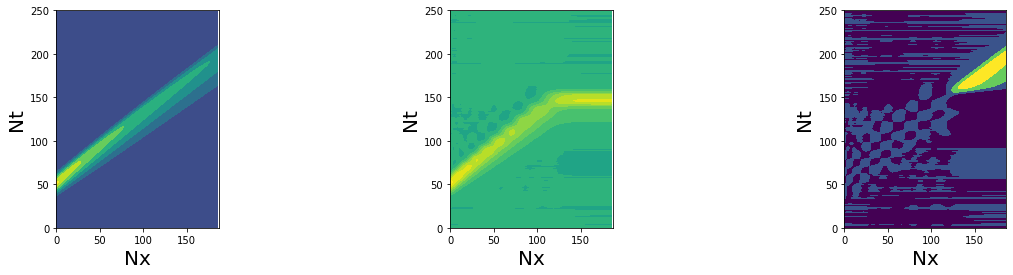

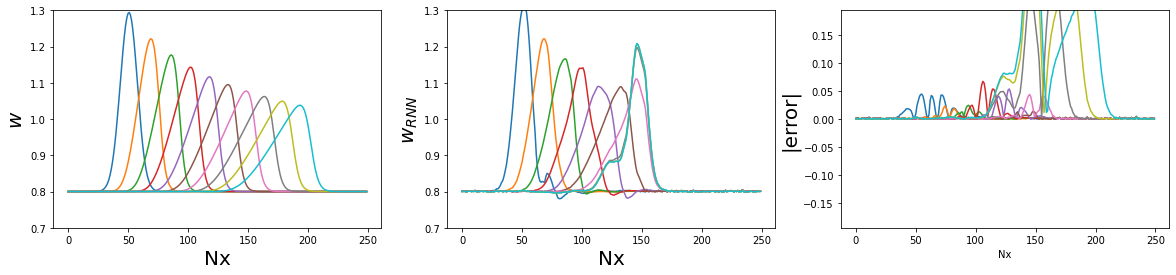

In [13]:
fig = plt.figure(figsize=(20, 4));

ax1 = plt.subplot(131, aspect='equal')
plt.contourf(X_E_FOM_ext,  vmin=ymin, vmax=ymax)
plt.xlim(0, Npred)
plt.ylim(0, 250)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)

ax1 = plt.subplot(132, aspect=1)
plt.contourf(y_pred_dec_M,  vmin=0*ymin, vmax=ymax)
plt.xlim(0, Npred)
plt.ylim(0, 250)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)

ax1 = plt.subplot(133, aspect=1)
plt.contourf(X_E_FOM_ext-y_pred_dec_M, vmin=0, vmax=0.15*ymax)
plt.ylim(0, 250)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)
#%%
dNt = 20
indices = ()
fig = plt.figure(figsize=(20, 4));
ax1 = plt.subplot(131)
plt.plot(np.transpose(X_E_FOM_ext[:,0:Npred:dNt].T));
plt.xlabel('Nx',  fontsize=20)
plt.ylabel(r'$w$', fontsize=20)
plt.ylim(ymin, ymax )

ax1 = plt.subplot(132)
plt.plot(np.transpose(y_pred_dec_M[:,0:Npred:dNt].T));

plt.xlabel('Nx',  fontsize=20)
plt.ylabel(r'$w_{RNN}$', fontsize=20)
plt.ylim(ymin, ymax )


ax1 = plt.subplot(133)
plt.plot(np.abs(np.transpose(X_E_FOM_ext[:,0:Npred:dNt].T-y_pred_dec_M[:,0:Npred:dNt].T )) );

plt.xlabel('Nx')
plt.ylabel('|error|', fontsize=20)
plt.ylim(-0.15*ymax, 0.15*ymax )

MSE 

In [14]:
mse = tf.keras.losses.MeanSquaredError()
error_mse_train = mse(X_E_FOM_ext[:,0:Nt], y_pred_dec_M[:,0:Nt]).numpy()
error_mse_pred  = mse(X_E_FOM_ext[:,0:Npred], y_pred_dec_M[:,0:Npred]).numpy()
print('Training range: MSE',error_mse_train)
print('Including prediction: MSE', error_mse_pred)

Training range: MSE 7.793324766680598e-05
Including prediction: MSE 0.0027614065911620855


In [0]:
hist_name_file = "burgers_"+gridtype+"_Ensize"+str(Encoder_size)+"_RNNsize"+str(RNN_size)+"_history.txt"
f=open(hist_name_file,'w')
for ele in train_history['mean_absolute_error']:
  f.write(str(ele)+'\n')

f.close()

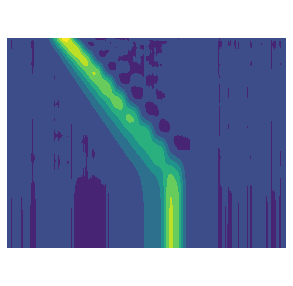

In [16]:
fig = plt.figure(figsize=(5, 5))
ax1=plt.subplot(111)
plt.contourf(y_pred_dec_M[:,].T,  vmin=ymin, vmax=ymax);
#plt.contourf(X_E_FOM_ext[:,].T,  vmin=ymin, vmax=ymax);
plt.ylim(0, Npred-1);
plt.xlim(0, 250);
plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.savefig("pred.png", bbox_inches='tight')

In [17]:
ymin


0.7

In [18]:
ymax

1.3